<center>
<h4>Diplomatura Datos 2021 - FaMAF - UNC</h4>
<h1>Aplicando Machine Learning para predicción de demanda</h1>
<h3>Exploración y Curación</h3>
</center>
</left>
<h4>Dario Yvanoff</h4>
</left>

[Proyecto para Mentoría](https://sites.google.com/view/mentorias2021-diplodatos/aplicando-machine-learning-para-predicci%C3%B3n-de-demanda?authuser=0)

# Información Importante

En la presente notebook, se presentará la consigna a seguir para el tercer práctico correspondiente a las materias Introducción al Aprendizaje Automático y Aprendizaje Automático Supervisado. En esta notebook se enumeran las consignas que permitirán implementar los pasos necesarios en la aplicación de diferentes métodos de aprendizaje supervisado incluyendo métodos de ensemble learning. Se realizarán experimentos reproducibles para luego proceder a la evaluación de los métodos mas convenientes y la selección de hiperparámetros a partir del cálculo de las métricas pertinentes.

El objetivo final de la mentoría es poder predecir el próximo mes de venta de productos en localidades donde opera la compañía de retail proveedora de los datasets. Concretamente vamos a intentar predecir el proximo mes para una localidad dada. Sin embargo, los prácticos que se realizarán en esta mentoría son aplicables a compañías de cualquier vertical de negocio que quiera predecir la demanda.

Cada grupo debe armar un repositorio git o agregar al repositorio existente con las actividades de esta notebook. En dicho repositorio deben presentar:
- una notebook respondiendo las consignas de este práctico
- un informe (formato html, ppt o pdf) con las respuestas de este práctico. Dicho informe servirá de base para obtener la información a presentar en los videos intermedio y final de la mentoria. 

Se recomienda que el informe tenga las siguientes secciones:
- Introducción 
- Respuestas a los puntos del práctico
- Principales conclusiones




# Entregable 
Fecha de Entrega de este practico y el informe: 12/9/2021

# Introducción

Para cumplir con el objetivo de la mentoria necesitamos entender que nuestro dataset es una series de tiempo. Una serie de tiempo es una secuencia de observaciones tomadas secuencialmente en el tiempo. 
El pronóstico de series de tiempo implica tomar modelos, ajustarlos a datos históricos y luego usarlos para predecir observaciones futuras
Sin embargo, se puede transformar un problema de serie de tiempo en uno de ML Supervisado agregando lags o valores anteriores a un valor a predecir como una feature nueva. 
Este enriquecimiento del dataset se hizo en prácticos anteriores y se va a perfeccionar en este práctico. 

Otro tema a tener en cuenta es como realizar validación cruzada cuando trabajamos con series de tiempo. Cuando se trabaja con series de tiempo no es posible utilizar K-Fold Cross Validation dado que esta forma de validación cruzada no respeta el orden de las observaciones. Los problemas de series temporales requieren una validación basada en el tiempo en lugar de la validación kfold utilizada generalmente en los problemas de regresión. Kfold divide los datos de forma aleatoria y no tiene sentido comprobar la precisión del modelo mediante la predicción del período de tiempo pasado mediante el uso de datos de futuro. Por este motivo, las alternativas para la validación cruzada en datos de series de tiempo pueden ser Sliding Windows o Foward chaining cross validation. Ver https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html para mas información de Time Series cross-validation.




# Importacion de librerías

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os

from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = 50

# Consignas

### 1- Correr el script de exploración y curación

A los fines de realizar este práctico, se utilizará el dataset limpio obtenido en el práctico anterior. Se requiere ejecutar el archivo .py codificado en el práctico anterior para generar el dataset el cual carga los datos originales, aplicar la curación y genera un dataset resultante que utilizaremos como input a los modelos de machine learning.

A los fines de poder entrenar los modelos es valido filtrar aqui el dataset de entrada por la localidad Córdoba y provincia Córdoba a los fines de realizar los primeros experimentos sobre un subconjunto de datos de entrada. El dataset deberia agrupar la 'cantidad_pedida' por 'anio','week','sku','Localidad'

En esta etapa, pueden opcionalmente adicionar otros atributos que crean pertinentes a priori o que hayan encontrado interesantes por tener mayor correlación con la variable a predecir. Recordar que en prácticos previos se agrego lags y feature para medias moviles simples o ponderadas que deben estar presente en el dataset de entrada.

Tener en cuenta que la ciencia de datos es un **proceso circular, continuo y no lineal**. Es decir, si los datos requieren de mayor procesamiento para satisfacer las necesidades de algoritmos de ML, podemos volver a la etapa inicial para, por ejemplo, crear nuevas features, tomar decisiones diferentes sobre valores faltantes o valores atípicos (outliers), descartar features, entre otras.

In [2]:
# Ejecutar script de exploración y curación 
# %run <name of script.py> 
#
# leer el dataset resultante
# file_name='nombre_archivo.csv'
# df_raw = pd.read_csv(file_name)

df_raw = pd.read_csv('cordoba_dense.csv')
df_raw

,anio=2018,anio=2019,cantidad_pedida,cantidad_pedida_lag_t-1,cantidad_pedida_lag_t-2,cantidad_pedida_lag_t-3,cantidad_pedida_mean,cantidad_pedida_mean_w2,cantidad_pedida_mean_w3,categoria_depurada=banos capuccino leche y salsas,categoria_depurada=cucuruchos conos y vasos de pasta,categoria_depurada=decoracion y frutos,categoria_depurada=frizzio,categoria_depurada=grido cafe,categoria_depurada=grido mix,categoria_depurada=impulsivos,categoria_depurada=pack impulsivos via bana,categoria_depurada=pack postrestortas via bana,categoria_depurada=pack potes via bana,categoria_depurada=palitos crema frutal bombon,categoria_depurada=pote lts,categoria_depurada=productos via bana tipo a,categoria_depurada=productos via bana tipo b,categoria_depurada=sabores al agua,categoria_depurada=sabores al agua x lts via bana,...,sku=4741,sku=4742,sku=5049,sku=5068,sku=559,sku=561,sku=585,sku=586,sku=614,sku=615,sku=621,sku=891,sku=892,sku=893,sku=894,sku=896,sku=908,sku=911,sku=972,sku=977,sku=995,sku=otros,totalkg,"ubicacion=Córdoba, Córdoba",unidadkg
0,1.0,0.0,7.0,18.0,4.0,20.0,2.333333,3.416667,3.611111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.44,1.0,2.92
1,1.0,0.0,18.0,5.0,3.0,3.0,2.571429,2.535714,2.190476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.08,1.0,0.06
2,1.0,0.0,3.0,2.0,6.0,2.0,1.000000,1.500000,1.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.78,1.0,0.26
3,1.0,0.0,175.0,229.0,309.0,302.0,1.114650,1.129825,1.270805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1365.00,1.0,7.80
4,1.0,0.0,119.0,73.0,77.0,198.0,2.380000,2.296061,2.224401,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,702.10,1.0,5.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,0.0,1.0,1.0,2.0,5.0,4.0,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.01,1.0,0.01
1963,0.0,1.0,1.0,4.0,2.0,2.0,1.000000,1.166667,1.111111,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.10,1.0,2.10
1964,0.0,1.0,31.0,18.0,32.0,14.0,2.066667,1.851515,1.795747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,291.09,1.0,9.39
1965,0.0,1.0,8.0,7.0,10.0,6.0,1.333333,1.250000,1.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20.48,1.0,2.56


### 2. Multicolinealidad Exacta

La multicolinealidad es la relación de dependencia lineal fuerte entre más de dos variables explicativas en una regresión múltiple que incumple el supuesto de Gauss-Markov cuando es exacta. En otras palabras, la multicolinealidad es la correlación alta entre más de dos variables explicativas lo cual deriva en la imposibilidad de estimar los parámetros cuando la misma es exacta o en estimaciones muy imprecisas cuando la misma es aproximada.

En el caso de encontrar multicolinealidad, responder: ¿Cómo se puede solucionar? ¿Qué decisión tomarían al respecto?. Adicionalmente eliminar las columnas pertinentes.

A continuación puede explorar un ejemplo de como remover multicolinealidad 

https://www.kaggle.com/remilpm/how-to-remove-multicollinearity


In [3]:
# Código para remover multicolinealidad
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [4]:
Mult_Coll = ReduceVIF(thresh=15)
df_1 = Mult_Coll.fit_transform(df_raw)
df_1

ReduceVIF fit
ReduceVIF transform


c:\users\sofia\appdata\local\programs\python\python39\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\users\sofia\appdata\local\programs\python\python39\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dropping anio=2018 with vif=inf
Dropping categoria_depurada=banos capuccino leche y salsas with vif=inf
Dropping categoria_depurada=pack impulsivos via bana with vif=inf
Dropping categoria_depurada=pack postrestortas via bana with vif=inf
Dropping categoria_depurada=pack potes via bana with vif=inf
Dropping categoria_depurada=semifrios with vif=inf
Dropping id_proveedor=2 with vif=inf
Dropping marca_depurada=frizzio with vif=inf
Dropping mes=10 with vif=inf
Dropping presentacion_depurada=baldes with vif=inf
Dropping sku=1022 with vif=inf
Dropping marca_depurada=via bana with vif=975.2605151151564
Dropping id_proveedor=3 with vif=223.31025403922513
Dropping sku=otros with vif=195.8635689988493
Dropping marca_depurada=grido with vif=152.36734951677496
Dropping presentacion_depurada=no asignada with vif=88.28557155675831
Dropping categoria_depurada=decoracion y frutos with vif=55.586864517683544
Dropping categoria_depurada=productos via bana  tipo a with vif=43.79422940300103
Dropping pre

,anio=2019,cantidad_pedida,cantidad_pedida_lag_t-1,cantidad_pedida_lag_t-2,cantidad_pedida_lag_t-3,cantidad_pedida_mean,cantidad_pedida_mean_w2,cantidad_pedida_mean_w3,categoria_depurada=cucuruchos conos y vasos de pasta,categoria_depurada=grido cafe,categoria_depurada=grido mix,categoria_depurada=impulsivos,categoria_depurada=palitos crema frutal bombon,categoria_depurada=pote lts,categoria_depurada=productos via bana tipo b,categoria_depurada=sabores al agua,categoria_depurada=sabores al agua x lts via bana,categoria_depurada=sabores comunes,categoria_depurada=sabores comunes x lts via bana,categoria_depurada=sabores especiales,categoria_depurada=sabores especiales x lts via bana,categoria_depurada=sabores premium,categoria_depurada=sabores premium x lts via bana,categoria_depurada=sundae go,categoria_depurada=tortas y postres,...,sku=4740,sku=4741,sku=4742,sku=5049,sku=5068,sku=559,sku=561,sku=585,sku=586,sku=614,sku=615,sku=621,sku=891,sku=892,sku=893,sku=894,sku=896,sku=908,sku=911,sku=972,sku=977,sku=995,totalkg,"ubicacion=Córdoba, Córdoba",unidadkg
0,0.0,7.0,18.0,4.0,20.0,2.333333,3.416667,3.611111,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.44,1.0,2.92
1,0.0,18.0,5.0,3.0,3.0,2.571429,2.535714,2.190476,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.08,1.0,0.06
2,0.0,3.0,2.0,6.0,2.0,1.000000,1.500000,1.400000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.78,1.0,0.26
3,0.0,175.0,229.0,309.0,302.0,1.114650,1.129825,1.270805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1365.00,1.0,7.80
4,0.0,119.0,73.0,77.0,198.0,2.380000,2.296061,2.224401,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,702.10,1.0,5.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,1.0,1.0,2.0,5.0,4.0,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,1.0,0.01
1963,1.0,1.0,4.0,2.0,2.0,1.000000,1.166667,1.111111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.10,1.0,2.10
1964,1.0,31.0,18.0,32.0,14.0,2.066667,1.851515,1.795747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,291.09,1.0,9.39
1965,1.0,8.0,7.0,10.0,6.0,1.333333,1.250000,1.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.48,1.0,2.56


In [5]:
# Sacamos la columna totalkg porque se derivaba de la que queremos predecir: cantidad_pedida
# Y la de ubicacion, densidad y poblacion porque en este caso es siempre Córdoba, Córdoba
df_1 = df_1.drop('totalkg',axis=1)
df_1 = df_1.drop('ubicacion=Córdoba, Córdoba',axis=1)
df_1 = df_1.drop('densidad_prov',axis=1)
df_1 = df_1.drop('poblacion_prov',axis=1)
# Agregamos de nuevo algunas columnas que podrian ser importantes
df_1['mes=10'] = df_raw['mes=10']
df_1

,anio=2019,cantidad_pedida,cantidad_pedida_lag_t-1,cantidad_pedida_lag_t-2,cantidad_pedida_lag_t-3,cantidad_pedida_mean,cantidad_pedida_mean_w2,cantidad_pedida_mean_w3,categoria_depurada=cucuruchos conos y vasos de pasta,categoria_depurada=grido cafe,categoria_depurada=grido mix,categoria_depurada=impulsivos,categoria_depurada=palitos crema frutal bombon,categoria_depurada=pote lts,categoria_depurada=productos via bana tipo b,categoria_depurada=sabores al agua,categoria_depurada=sabores al agua x lts via bana,categoria_depurada=sabores comunes,categoria_depurada=sabores comunes x lts via bana,categoria_depurada=sabores especiales,categoria_depurada=sabores especiales x lts via bana,categoria_depurada=sabores premium,categoria_depurada=sabores premium x lts via bana,categoria_depurada=sundae go,categoria_depurada=tortas y postres,...,sku=4739,sku=4740,sku=4741,sku=4742,sku=5049,sku=5068,sku=559,sku=561,sku=585,sku=586,sku=614,sku=615,sku=621,sku=891,sku=892,sku=893,sku=894,sku=896,sku=908,sku=911,sku=972,sku=977,sku=995,unidadkg,mes=10
0,0.0,7.0,18.0,4.0,20.0,2.333333,3.416667,3.611111,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.92,0.0
1,0.0,18.0,5.0,3.0,3.0,2.571429,2.535714,2.190476,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0
2,0.0,3.0,2.0,6.0,2.0,1.000000,1.500000,1.400000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26,0.0
3,0.0,175.0,229.0,309.0,302.0,1.114650,1.129825,1.270805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.80,0.0
4,0.0,119.0,73.0,77.0,198.0,2.380000,2.296061,2.224401,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.90,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,1.0,1.0,2.0,5.0,4.0,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0
1963,1.0,1.0,4.0,2.0,2.0,1.000000,1.166667,1.111111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.10,0.0
1964,1.0,31.0,18.0,32.0,14.0,2.066667,1.851515,1.795747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.39,0.0
1965,1.0,8.0,7.0,10.0,6.0,1.333333,1.250000,1.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.56,0.0


In [6]:
# Analizamos ahora la matriz de correlacion
corr = df_1.corr()
corr.head()

,anio=2019,cantidad_pedida,cantidad_pedida_lag_t-1,cantidad_pedida_lag_t-2,cantidad_pedida_lag_t-3,cantidad_pedida_mean,cantidad_pedida_mean_w2,cantidad_pedida_mean_w3,categoria_depurada=cucuruchos conos y vasos de pasta,categoria_depurada=grido cafe,categoria_depurada=grido mix,categoria_depurada=impulsivos,categoria_depurada=palitos crema frutal bombon,categoria_depurada=pote lts,categoria_depurada=productos via bana tipo b,categoria_depurada=sabores al agua,categoria_depurada=sabores al agua x lts via bana,categoria_depurada=sabores comunes,categoria_depurada=sabores comunes x lts via bana,categoria_depurada=sabores especiales,categoria_depurada=sabores especiales x lts via bana,categoria_depurada=sabores premium,categoria_depurada=sabores premium x lts via bana,categoria_depurada=sundae go,categoria_depurada=tortas y postres,...,sku=4739,sku=4740,sku=4741,sku=4742,sku=5049,sku=5068,sku=559,sku=561,sku=585,sku=586,sku=614,sku=615,sku=621,sku=891,sku=892,sku=893,sku=894,sku=896,sku=908,sku=911,sku=972,sku=977,sku=995,unidadkg,mes=10
anio=2019,1.000000,0.022481,-0.004985,-0.009627,-0.034011,0.028251,0.012009,0.001422,0.010318,0.147105,-0.004931,-0.021228,0.030383,0.025421,-0.006109,-0.006764,-0.104608,-0.014165,-0.191260,-0.038875,-0.137328,0.003580,-0.144654,0.023166,0.033404,...,0.029366,0.023801,0.029366,0.029366,0.004333,0.036373,0.005825,0.005825,0.005825,0.011162,0.005825,0.011229,0.011162,0.023801,0.005825,0.011375,0.017830,0.005825,-0.001342,0.011168,0.005825,0.005825,0.005825,0.003529,-0.000036
cantidad_pedida,0.022481,1.000000,0.689759,0.511465,0.428658,0.186024,0.192708,0.182344,-0.130935,-0.116499,-0.052094,0.079186,0.291872,0.382528,-0.157533,0.038170,-0.034378,0.054739,0.050403,0.050414,0.040116,0.059340,-0.030217,-0.048692,0.064015,...,-0.037441,-0.024565,-0.054444,-0.024596,0.022068,0.028161,-0.064786,-0.064184,-0.058706,-0.066658,0.010976,-0.007311,-0.066771,-0.003449,0.093368,0.012106,-0.001859,0.054418,0.153249,0.153916,-0.066265,-0.079577,-0.002993,-0.046121,0.057872
cantidad_pedida_lag_t-1,-0.004985,0.689759,1.000000,0.676231,0.583749,0.124399,0.169791,0.171273,-0.123049,-0.098217,-0.042002,0.069969,0.251454,0.343059,-0.119617,0.035129,-0.020419,0.142260,0.097236,0.060818,0.031621,0.061709,-0.031058,-0.028830,0.177831,...,-0.020265,-0.016586,-0.043208,-0.021235,0.002065,0.076966,-0.057920,-0.057363,-0.054751,-0.058562,-0.005934,-0.018951,-0.058826,-0.006320,0.053974,0.009231,-0.003633,0.028238,0.124221,0.110762,-0.058648,-0.068539,-0.016982,-0.033269,0.046508
cantidad_pedida_lag_t-2,-0.009627,0.511465,0.676231,1.000000,0.797529,0.068247,0.095182,0.126335,-0.117355,-0.084004,-0.034782,0.049652,0.285644,0.281476,-0.093080,0.052285,-0.018234,0.148342,0.069263,0.065020,0.009798,0.059746,-0.036107,-0.015414,0.185765,...,-0.014589,-0.014352,-0.036288,-0.017566,-0.010199,0.088595,-0.052379,-0.051229,-0.049784,-0.052049,-0.014724,-0.021419,-0.052489,-0.003811,0.042417,0.021142,0.002877,0.017609,0.091452,0.078902,-0.051361,-0.059181,-0.024220,-0.025495,-0.027496
cantidad_pedida_lag_t-3,-0.034011,0.428658,0.583749,0.797529,1.000000,0.025412,0.053648,0.079174,-0.117289,-0.079646,-0.028434,0.060293,0.347806,0.257107,-0.088304,0.069938,-0.016660,0.120572,0.076815,0.073570,0.000835,0.048169,-0.037856,-0.014717,0.127465,...,-0.009923,-0.013498,-0.031596,-0.016861,-0.011995,0.101140,-0.051127,-0.050930,-0.049048,-0.049504,-0.020250,-0.018880,-0.051267,-0.000918,0.032092,0.033478,0.010897,0.002030,0.091135,0.063759,-0.048626,-0.056578,-0.028679,-0.017969,-0.094992


<AxesSubplot:>

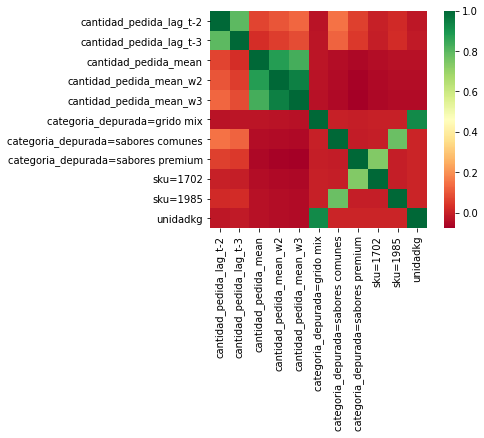

In [7]:
indices = corr[(corr.values>0.7) & (corr.values!=1)].index.unique()
corr_positiva = corr.loc[indices,indices]
sns.heatmap(corr_positiva, square=True, cmap='RdYlGn')

Los lags y las medias moviles estan muy relacionados entre si (es de esperarse), pero se puede eliminar la categoria grido mix que esta muy correlacionada con unidadkg y las categorias sabores comunes y sabores premium que estan muy correlacionadas con los sku 1985 y 1702 respectivamente

In [8]:
df_1 = df_1.drop('categoria_depurada=grido mix',axis=1)
df_1 = df_1.drop('categoria_depurada=sabores comunes',axis=1)
df_1 = df_1.drop('categoria_depurada=sabores especiales',axis=1)

In [9]:
indices = corr[(corr.values<-0.7) & (corr.values!=1)].index.unique()
len(indices)

0

No hay columnas con alta correlacion negativa

### 3. Comprobacion Time Serie Stationary and Trend

Para poder realizar predicciones mas adecuadas necesitamos que las series de tiempo no estacionarias se conviertan en estacionarias y remover las tendencias. Para poder identificar estas condiciones podemos utilizar "ADF test" el cual es un test estadístico para chequear la estacionalidad de una serie, y "KPSS test" el cual es un test estadístico para chequear que serie estacionaria entorno a una tendencia deterministica.

Profundicemos sobre los diferentes tipos de estacionariedad y cómo interpretar los resultados de las pruebas.

**Estacionaria estricta:** Una serie estacionaria estricta satisface la definición matemática de un proceso estacionario. Para una serie estacionaria estricta, la media, la varianza y la covarianza no están en función del tiempo. Lo deseable y objetivo principal es convertir una serie no estacionaria en una serie estricta estacionaria para realizar predicciones.

**Tendencia estacionaria:** Una serie que no tiene raíz unitaria pero que muestra una tendencia se denomina serie estacionaria con tendencia. Una vez que se elimina la tendencia, la serie resultante será estrictamente estacionaria. Verifique sus datos con la prueba KPSS. La prueba KPSS clasifica una serie como estacionaria en ausencia de raíz unitaria. Esto significa que la serie puede ser estrictamente estacionaria o de tendencia estacionaria.

**Diferencia estacionaria:** Una serie de tiempo que se puede hacer estrictamente estacionaria diferenciando se encuadra bajo diferencia estacionaria. La prueba ADF también se conoce como prueba de estacionariedad de diferencia.

Entonces, en general, lo que esto significa para nosotros es que, si una serie es estacionaria según la prueba KPSS estableciendo regression = 'ct' y no es estacionaria según la prueba ADF, significa que la serie está estacionaria en torno a una tendencia determinista y, por lo tanto, es bastante fácil de modelar esta serie y producir pronósticos bastante precisos pues incorporando una nueva feature que sea la diferencia entre la variable dependiente y su valor (shift) anterior enriquecerá el dataset lo suficiente como para eliminar la tendencia.

Casos luego de implementar los test:

Case 1: ambos test concluyen que la serie es no estacionaria -> la serie es no estacionaria

Case 2: ambos test concluyen que la serie es estacionaria -> la serie es estacionaria

Case 3: KPSS = estacionaria and ADF = no estacionaria  -> tendencia estacionaria, remover la tendencia para convertir la serie en estacionaria estricta.

Case 4: KPSS = no estacionaria and ADF = estacionaria -> diferencia estacionaria, use diferenciacion para convertir la serie a estacionaria

Mas info en:
https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

A continuación se proveen las funciones de los test estadísticos de ADF y KPSS

#### Definicion de Funciones

In [10]:
# ADF test (test para verificar si es serie estacionaria)
# Ho) la serie es NO estacionaria (p-value < alpha para rechazar ho)
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [11]:
# KPSS (test para verificar si es una serie estacionaria alrededor de una tendencia deterministica)
# Ho) Serie es estacionaciaria (p-value < alpha para rechazar ho)
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='ct')#, nlags='auto'
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

#### Cantidad Pedida

In [12]:
#Test de ADF
adf_test(df_1['cantidad_pedida'])

Results of Dickey-Fuller Test:
Test Statistic                  -19.870193
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1963.000000
Critical Value (1%)              -3.433686
Critical Value (5%)              -2.863013
Critical Value (10%)             -2.567554
dtype: float64


El p-value es menor al alpha. Con un nivel de significancia de 0.05 se rechaza la hipotesis nula de que la serie es no estacionaria. En otras palabras, se puede concluir que la ***serie es estacionaria***. 

In [13]:
#Test de KPSS
kpss_test(df_1['cantidad_pedida'])

Results of KPSS Test:
Test Statistic            0.130142
p-value                   0.079367
Lags Used                26.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


c:\users\sofia\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


El p-value es mayor al alpha. Con un nivel de significancia de 0.05 **no** hay evidencia suficiente para rechazar la hipotesis nula de que la serie es estacionaria entorno a una tendecia deterministica. En otras palabras, se puede conluir que la ***serie es estacionaria*** en torno a una tendencia deterministica.

Ambos test caracterizaron a la serie como estacionaria, por lo tanto, la serie es estacionaria estricta

<AxesSubplot:>

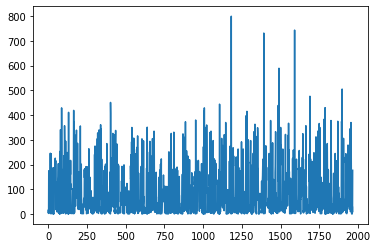

In [14]:
df_1['cantidad_pedida'].plot()

<AxesSubplot:>

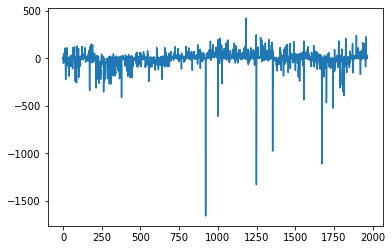

In [15]:
#Calculamos la diferencia estacionaria 
df_1['cantidad_pedida_dif'] =  df_1['cantidad_pedida'] - df_1['cantidad_pedida_lag_t-1']
df_1['cantidad_pedida_dif'].plot()

### 4. Normalización y Estandarización de Atributos

Algunos algoritmos de aprendizaje automático lograrán un mejor rendimiento si sus datos de series de tiempo tienen una escala o distribución consistente.

Aplicar a los datasets la normalización y estandarizacion de atributos que consideren adecuada en el caso que aplique o sea necesario. 

Ejemplo https://machinelearningmastery.com/normalize-standardize-time-series-data-python/


Respuesta: Para algoritmos basados en arboles, como XGBoost o Random Forest, no es necesario escalar la data, pero para K neighbors sí es conveniente aplicar por ejemplo el MinMaxScaler. Esto se hará en la sección correspondiente al ajuste de hiperparametros del KNR

### 5. División en Train/Test y Aplicando Modelos

Finalmente, están en condiciones de **dividir el dataset en Train y Test**, utilizando para este último conjunto un 20% de los datos disponibles. Teniendo en cuenta que estamos utilizando series temporales la división de train y test debe respetar la linea de tiempo. Esto es, el 80% de datos mas antiguos serán para train y el 20% mas recientes serán utilizados para test.

Con el fin de experimentar los distintos algoritmos de ML para predecir la demanda en esta notebook se presentarán los distintos modelos que podría utilizar sobre los cuales deberán realizar sucesivas corridas con distintos hiperparámetros e identificar cual es el mas conveniente en función a las métricas.


Los modelos que inicialmente puede utilizar son los siguientes:

- Linear Support Vector Regression ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR))
- Stochastic Gradient Descent ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor))
- KNeighborsRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor))
- Prediction Voting Regressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor))
- XGBRegressor  ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html)) 
- Random Forest Regressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) 
- LGBMRegressor ([Doc](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)) 

De estos tipos de modelos, cuál creen que es el más adecuado para nuestro caso de aplicación? 

**Elegir el modelo o los modelos que consideren que mejor aplica a nuestro problema.** Para ello, recuerden que los pasos a seguir en la selección pueden esquematizarse como sigue:

#### - Selección de Regularizador

 ¿Utilizarán algún regularizador?¿Cuál?

#### - Selección de Función de Costo

¿Cuál será la función de costo utilizada?

#### - Justificación de las Selecciones

¿Por qué eligieron el modelo, el regularizador y la función de costo previas?

Finalmente, para el modelo selecionado:

- Utilizar el método *Grid Search*, o de búsqueda exahustiva, con *cross-validation* para profundizar en la búsqueda y selección de hiperparámetros.

- Calcular métricas (https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) sobre el conjunto de entrenamiento y de evaluación para los mejores parámetros obtenidos:
    + MAPE, MSE, MAE, RMSE, R Square
    + Comparar las métricas obtenidas en cada modelo y obtener conclusiones.

Si encuentran cualquier otro modelo que consideren apropiado y deseen aplicar, pueden hacerlo con total libertad.


In [42]:
# Ejemplo de Modelos. Adicione aqui los modelos con los que desee experimentar
modelos = {'XGB': XGBRegressor(seed=42),
           'RFR': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
           'KNR': KNeighborsRegressor(n_neighbors=3),
           'LGBM': LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='regression', min_split_gain=0.0,min_child_samples=20,subsample=1.0,subsample_freq=0,colsample_bytree=1.0,reg_alpha=0.0,reg_lambda=0.0,random_state=None,silent=True),
           #'LSVR': LinearSVR(epsilon=0, C=0.3, fit_intercept=True,max_iter=10000),
           #'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
           'VOT': VotingRegressor([('XGB', XGBRegressor(seed=42)), ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))])
           #'SGD': SGDRegressor(max_iter=2000, tol=1e-3)
          }

In [17]:
df = df_1.copy()

# Seleccion de Periodo
periodos_todos = {'Completo': df,
            '2018': df[df['anio=2019']==0],
            '2019': df[df['anio=2019']==1]
           }

periodos_completo = {'Completo': df}

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

def comparar_modelos_default(modelos, periodos, proporcion_train=0.8):
    
    summary_list = []

    for periodo, filtro in periodos.items():  
        print('Periodo', periodo)
        print('Shape ', filtro.shape)
        df = filtro.copy()

        split = int(df.shape[0]*proporcion_train)

        df.loc[df.iloc[:split].index, 'train_test'] = 'train'
        df.loc[df.iloc[split:].index, 'train_test'] = 'test'

        x_train = df[df['train_test']=='train'].copy()
        x_test = df[df['train_test']=='test'].copy()

        y_train = x_train['cantidad_pedida'].copy()
        y_test = x_test['cantidad_pedida'].copy()

        x_train = x_train.drop(columns=['cantidad_pedida', 'train_test'])
        x_test = x_test.drop(columns=['cantidad_pedida', 'train_test'])
        
        print('Resultados con cross validation en el train set:')
        results = []
        names = []
        for name, model in modelos.items():
            # TimeSeries Cross validation
            tscv = TimeSeriesSplit(n_splits=10)
            cv_results = cross_val_score(model, x_train, y_train, cv=tscv, scoring='r2')
            results.append(cv_results)
            names.append(name)
            print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

        # Compare Algorithms
        plt.boxplot(results, labels=names)
        plt.title('Algorithm Comparison')
        plt.show()
        
        for nom_modelo, modelo in modelos.items():
            summary = dict()
            summary['periodo'] = periodo
            summary['modelo'] = nom_modelo
            modelo.fit(x_train, y_train)
            y_pred = modelo.predict(x_test)
            summary['rmse'] = np.sqrt(mean_squared_error(y_test, y_pred))
            summary['mape'] = mean_absolute_percentage_error(y_test, y_pred)
            summary['r2'] = r2_score(y_test,y_pred)
            summary_list.append(summary)
        
    print('Resultados en el test set:')
    df_results = pd.DataFrame(summary_list) 
    
    return df_results

Periodo Completo
Shape  (1967, 134)
Resultados con cross validation en el train set:
XGB: 0.920274 (0.050359)
RFR: 0.908855 (0.058415)
KNR: 0.861106 (0.047585)
LGBM: 0.918162 (0.070495)
VOT: 0.919370 (0.052327)


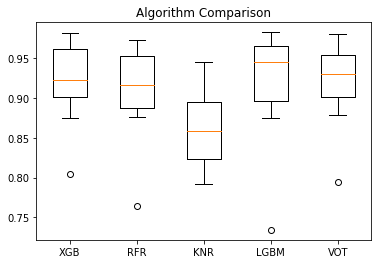

Periodo 2018
Shape  (1043, 134)
Resultados con cross validation en el train set:
XGB: 0.870645 (0.089593)
RFR: 0.858246 (0.088750)
KNR: 0.793365 (0.080351)
LGBM: 0.839732 (0.118864)
VOT: 0.873245 (0.086075)


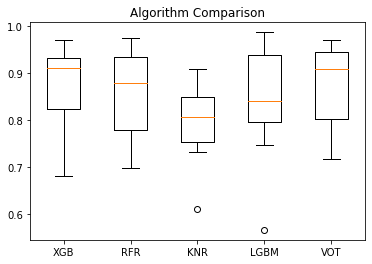

Periodo 2019
Shape  (924, 134)
Resultados con cross validation en el train set:
XGB: 0.898296 (0.059881)
RFR: 0.880476 (0.079968)
KNR: 0.838557 (0.070252)
LGBM: 0.888664 (0.093761)
VOT: 0.897873 (0.064126)


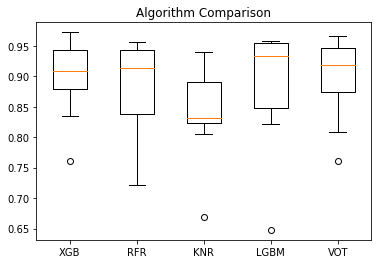

Resultados en el test set:


,periodo,modelo,rmse,mape,r2
0,Completo,XGB,21.971708,0.275104,0.956069
1,Completo,RFR,21.923149,0.258818,0.956263
2,Completo,KNR,34.777364,0.499609,0.889938
3,Completo,LGBM,25.378882,0.230821,0.941388
4,Completo,VOT,21.219175,0.259929,0.959027
5,2018,XGB,22.596945,0.307551,0.952980
6,2018,RFR,25.890154,0.379482,0.938276
7,2018,KNR,37.987666,0.539716,0.867117
8,2018,LGBM,35.913152,0.302217,0.881234
9,2018,VOT,22.849414,0.331499,0.951923


In [43]:
comparar_modelos_default(modelos, periodos_todos)

### 6. Grid Search de los Modelos Seleccionados

In [20]:
# División en train y test - Uso el periodo completo (2018 y 2019)
train = 0.8
test = 1 - train

df = df_1.copy()   
split = int(df.shape[0]*train)
    
df.loc[df.iloc[:split].index, 'train_test'] = 'train'
df.loc[df.iloc[split:].index, 'train_test'] = 'test'
    
x_train = df[df['train_test']=='train'].copy()
x_test = df[df['train_test']=='test'].copy()
    
y_train = x_train['cantidad_pedida'].copy()
y_test = x_test['cantidad_pedida'].copy()

x_train = x_train.drop(columns=['cantidad_pedida', 'train_test'])
x_test = x_test.drop(columns=['cantidad_pedida', 'train_test'])

# Creación de folds
tscv = TimeSeriesSplit(n_splits=10)

In [21]:
# Función para imprimir todas las metricas relevantes 
def best_model_metrics(fitted_gs_cv, x_test, y_test, results=False, save=False, name='resultados', ret=False):
    best_model = fitted_gs_cv.best_estimator_
    best_params = fitted_gs_cv.best_params_
    best_score = fitted_gs_cv.best_score_
    y_pred = best_model.predict(x_test)
    print('R2 score promedio del modelo en train set:', best_score)
    print('R2 score en test set:', r2_score(y_test, y_pred))
    print('rmse score en test set:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('mape score en test set:', mean_absolute_percentage_error(y_test, y_pred))
    print('\n Parametros:')
    print(best_params)
    if results:
        results = fitted_gs_cv.cv_results_
        df = pd.DataFrame(results)
        print('\n Resultados de los mejores 10 modelos:')
        print(df[df.rank_test_score<11].iloc[:,4:])
        if 'mean_train_score' in list(df.columns):
            df['dif_mean_train_test_score']=df['mean_train_score']-df['mean_test_score']
            print('\n Resultados de los 10 modelos con menor diferencia entre train y test:')
            df_top = df[df.rank_test_score<51].iloc[:,4:]
            print(df_top.sort_values('dif_mean_train_test_score').head(10)) 
        if save:
            df.to_csv(name) 
    if ret:
        ret = {'best_model': best_model, 'best_params': best_params, 'best_score': best_score, 'resultados': df}
    else:
        ret = None
    return ret

In [22]:
def comparar_modelos(modelos, x_train, x_test, y_train, y_test):
    
    summary_list = []

    print('Resultados con cross validation en el train set para el período completo (2018-2019):')
    results = []
    names = []
    for name, model in modelos.items():
        cv_results = cross_val_score(model, x_train, y_train, cv=tscv, scoring='r2')
        results.append(cv_results)
        names.append(name)
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison')
    plt.show()
       
    for nom_modelo, modelo in modelos.items():
        summary = dict()
        summary['modelo'] = nom_modelo
        modelo.fit(x_train, y_train)
        y_pred = modelo.predict(x_test)
        summary['rmse'] = np.sqrt(mean_squared_error(y_test, y_pred))
        summary['mape'] = mean_absolute_percentage_error(y_test, y_pred)
        summary['r2'] = r2_score(y_test,y_pred)
        summary_list.append(summary)
        
    print('Resultados en el test set:')
    df_results = pd.DataFrame(summary_list) 
    
    return df_results

### Random Forest - Ajuste de hiperparámetros

Random Forest no necesita que los datos esten normalizados ni escalados

In [23]:
model = RandomForestRegressor(random_state=0)
param_search = { 
   'n_estimators': [20, 50, 100],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth' : [i for i in range(5,15)],
   'criterion': ['mse', 'mae'], 
   'min_samples_leaf': [1,2,3]
}

gs_cv_rf = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gs_cv_rf.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(random_state=0),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [20, 50, 100]},
             scoring='r2')

In [24]:
best_model_metrics(gs_cv_rf, x_test, y_test, results=True)

R2 score promedio del modelo en train set: 0.9127340847370471
R2 score en test set: 0.9555138952602372
rmse score en test set: 22.110114788538453
mape score en test set: 0.2668658530583939

 Parametros:
{'criterion': 'mse', 'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 50}

 Resultados de los mejores 10 modelos:
    param_criterion param_max_depth param_max_features param_min_samples_leaf  \
85              mse               8               auto                      2   
86              mse               8               auto                      2   
140             mse              10               auto                      2   
166             mse              11               auto                      2   
167             mse              11               auto                      2   
193             mse              12               auto                      2   
194             mse              12               auto                      2   
221 

In [23]:
# Argumentos por default
rf0 = RandomForestRegressor(random_state=0)
# Mejor del gridsearch
rf1 = RandomForestRegressor(random_state=0, criterion='mse', max_depth=11, max_features='auto', min_samples_leaf=2, n_estimators=50)

Resultados con cross validation en el train set para el período completo (2018-2019):
Random Forest baseline: 0.907999 (0.055913)
Random Forest optimizado: 0.912734 (0.060771)


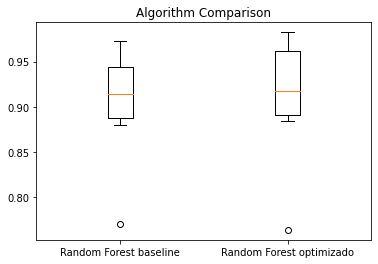

Resultados en el test set:


,modelo,rmse,mape,r2
0,Random Forest baseline,23.355481,0.261845,0.950361
1,Random Forest optimizado,22.110115,0.266866,0.955514


In [24]:
modelos_rf = {'Random Forest baseline': rf0, 
              'Random Forest optimizado': rf1}
comparar_modelos(modelos_rf, x_train, x_test, y_train, y_test)

### XGBoost - Ajuste de hiperparámetros

XGB no necesita que los datos esten normalizados ni escalados

In [54]:
# Grid Search para xgboost
param_grid_xgb_random = {
    'max_depth': list(np.arange(1, 10)),
    'n_estimators': list(np.arange(100, 1001, 100)),
    'learning_rate': list(np.arange(0.1, 0.41, 0.1)),
    'colsample_bytree': list(np.arange(0.5, 1.01, 0.1)),
    'subsample': list(np.arange(0.6, 1.01, 0.1))
}
model =  XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=0)

rgs_cv_xgb = RandomizedSearchCV(estimator=model, param_distributions=param_grid_xgb_random, n_iter=100, scoring='r2', cv=tscv, n_jobs=2, verbose=2, random_state=0)
rgs_cv_xgb.fit(x_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          eval_metric='logloss', gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max...
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7,
                                                             0.7999999999999999,
                                                             0.8999999999999999,
                                     

In [113]:
resultados_xgb = best_model_metrics(rgs_cv_xgb, x_test, y_test, results=True, save=True, name='xgb1.csv', ret=True)

R2 score promedio del modelo en train set: 0.9586994462322982
R2 score en test set: 0.9859684537571155
rmse score en test set: 12.417425790410086
mape score en test set: 0.2039814671997491

 Parametros:
{'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 1, 'learning_rate': 0.30000000000000004, 'colsample_bytree': 0.6}

 Resultados de los mejores 10 modelos:
   param_subsample param_n_estimators param_max_depth param_learning_rate  \
0              0.8                700               1                 0.3   
8              1.0                500               1                 0.2   
15             0.9                400               3                 0.2   
27             0.7                500               2                 0.1   
39             0.6               1000               1                 0.3   
44             0.8                900               1                 0.2   
49             0.9                400               1                 0.4   
51             0.7   

In [25]:
# Mejor del random gridsearch
xgb1 = XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=0,
                    subsample=0.6, n_estimators=1000, max_depth=1, learning_rate=0.3, colsample_bytree=0.6)

In [57]:
param_grid_xgb = {
    'max_depth': list(np.arange(1, 2)),
    'n_estimators': list(np.arange(700, 1001, 100)),
    'learning_rate': [0.1, 0.2, 0.3],
    'colsample_bytree': [0.6, 0.8, 1],
    'subsample': [0.6, 0.8, 1]
}

In [59]:
model =  XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=0)

gs_cv_xgb = GridSearchCV(estimator=model, param_grid=param_grid_xgb, scoring='r2', cv=tscv)
gs_cv_xgb.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    eval_metric='logloss', gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=0,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_m

In [114]:
resultados_xgb2 = best_model_metrics(gs_cv_xgb, x_test, y_test, results=True, save=True, name='xgb2.csv', ret=True)

R2 score promedio del modelo en train set: 0.9617869762473127
R2 score en test set: 0.9878656015203631
rmse score en test set: 11.547499006937892
mape score en test set: 0.20150166441602055

 Parametros:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.6}

 Resultados de los mejores 10 modelos:
    param_colsample_bytree param_learning_rate param_max_depth  \
45                     0.8                 0.1               1   
51                     0.8                 0.2               1   
54                     0.8                 0.2               1   
57                     0.8                 0.2               1   
58                     0.8                 0.2               1   
81                       1                 0.1               1   
91                       1                 0.2               1   
94                       1                 0.2               1   
102                      1                 0.3            

In [26]:
# Mejor del gridsearch
xgb2 = XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=0,
                    subsample=0.6, n_estimators=1000, max_depth=1, learning_rate=0.2, colsample_bytree=0.8)

Ahora voy a jugar un poco con los parametros de regularización

In [63]:
param_grid_xgb = {
    'max_depth': [1],
    'n_estimators': [900, 1000],
    'learning_rate': [0.2],
    'colsample_bytree': [0.8, 1],
    'subsample': [0.6, 0.8],
    'gamma': [0, 1, 2],
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1] 
}

In [64]:
model =  XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=0)

gs_cv_xgb_reg = GridSearchCV(estimator=model, param_grid=param_grid_xgb, scoring='r2', cv=tscv)
gs_cv_xgb_reg.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    eval_metric='logloss', gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, use_label_encoder=False,
                                    validate_parameters=None, verbosity=None),
             param_grid={'c

In [115]:
resultados_xgb3 = best_model_metrics(gs_cv_xgb_reg, x_test, y_test, results=True, save=True, name='xgb3.csv', ret=True)

R2 score promedio del modelo en train set: 0.9619965332432253
R2 score en test set: 0.9878652990603539
rmse score en test set: 11.547642921566066
mape score en test set: 0.20150376360846764

 Parametros:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.6}

 Resultados de los mejores 10 modelos:
    param_colsample_bytree param_gamma param_learning_rate param_max_depth  \
38                     0.8           0                 0.2               1   
46                     0.8           0                 0.2               1   
54                     0.8           0                 0.2               1   
62                     0.8           0                 0.2               1   
102                    0.8           1                 0.2               1   
110                    0.8           1                 0.2               1   
118                    0.8           1                 0.2

In [27]:
# Mejor del gridsearch con parametros de regularizacion
xgb3 = XGBRegressor(use_label_encoder=False, eval_metric='logloss', random_state=0,
                    subsample=0.6, n_estimators=1000, max_depth=1, learning_rate=0.2, colsample_bytree=0.8,
                    gamma=0, reg_alpha=0.01, reg_lambda=1)

Resultados con cross validation en el train set para el período completo (2018-2019):
XGB_1: 0.958699 (0.037216)
XGB_2: 0.961787 (0.037330)
XGB_3: 0.961997 (0.037221)


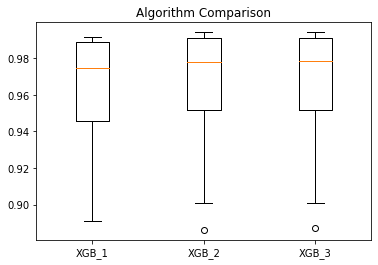

Resultados en el test set:


,modelo,rmse,mape,r2
0,XGB_1,12.417426,0.203981,0.985968
1,XGB_2,11.547499,0.201502,0.987866
2,XGB_3,11.547643,0.201504,0.987865


In [28]:
modelos_xgb = {'XGB_1': xgb1,
               'XGB_2': xgb2,
               'XGB_3': xgb3}
comparar_modelos(modelos_xgb, x_train, x_test, y_train, y_test)

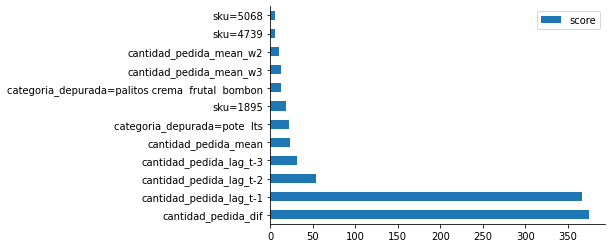

In [29]:
feature_important = xgb3.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False).head(12)
data.plot(kind='barh')
sns.despine()

### KNR - Ajuste de hiperparametros

In [30]:
# Aplicamos MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=list(x_train.columns))

x_test_scaled = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=list(x_test.columns))


scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_train.values.reshape(-1, 1))

y_train_scaled = scaler.transform(y_train.values.reshape(-1, 1))
y_train_scaled = pd.Series(y_train_scaled[:, 0], name=y_train.name)

y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
y_test_scaled = pd.Series(y_test_scaled[:, 0], name=y_test.name)

In [90]:
neighbors = list(range(1,8))

param_grid_knn = [
    {'n_neighbors': neighbors,
    'weights': ['uniform'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},    
    {'n_neighbors': neighbors,
    'weights': ['distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['chebyshev']},
    {'n_neighbors': neighbors,
    'weights': ['distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['minkowski'],
    'p': [2]}
]

In [91]:
model_knn = KNeighborsRegressor()

gs_cv_knn = GridSearchCV(estimator=model_knn, param_grid=param_grid_knn, scoring='r2', cv=tscv, verbose=2)
gs_cv_knn.fit(x_train_scaled, y_train_scaled)

Fitting 10 folds for each of 84 candidates, totalling 840 fits
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=2, w

[CV] END algorithm=ball_tree, n_neighbors=4, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=4, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=4, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=4, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=4, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=4, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree

[CV] END algorithm=auto, metric=chebyshev, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neighbors=4, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=chebyshev, n_neigh

[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=6, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=6, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=6, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=6, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=6, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=6, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=chebyshev, n_neighbors=6, weights=distance; total time=   0.0s


[CV] END algorithm=kd_tree, metric=chebyshev, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=chebyshev, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=chebyshev, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=chebyshev, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=chebyshev, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=chebyshev, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, me

[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=4, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=4, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=4, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=4, p=2, weights=distance; total time=   0.0s


[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=4, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=minkowski, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, metric=minkowski, n_neigh

[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=6, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, metric=minkowski, n_neighbors=6, p=2, weights

[CV] END algorithm=brute, metric=minkowski, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=minkowski, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=minkowski, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=minkowski, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=minkowski, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=minkowski, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=minkowski, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, metric=minkowski, n_neighbors=7, p=2, weights=distance; total time=   0.0s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsRegressor(),
             param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7],
                          'weights': ['uniform']},
                         {'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'metric': ['chebyshev'],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7],
                          'weights': ['distance']},
                         {'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'metric': ['minkowski'],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 'p': [2],
                          'weights': ['distance']}],
             scoring='r2', verbose=2)

In [92]:
resultados_knn = best_model_metrics(gs_cv_knn, x_test_scaled, y_test_scaled, results=True, save=True, name='knn2.csv', ret=True)

R2 score promedio del modelo en train set: 0.562929907893955
R2 score en test set: 0.6267574864665536
rmse score en test set: 0.08025488350129617
mape score en test set: 1954391205991.0415

 Parametros:
{'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

 Resultados de los mejores 10 modelos:
   param_algorithm param_n_neighbors param_weights param_metric param_p  \
4             auto                 5       uniform          NaN     NaN   
11       ball_tree                 5       uniform          NaN     NaN   
18         kd_tree                 5       uniform          NaN     NaN   
25           brute                 5       uniform          NaN     NaN   
59            auto                 4      distance    minkowski       2   
60            auto                 5      distance    minkowski       2   
66       ball_tree                 4      distance    minkowski       2   
67       ball_tree                 5      distance    minkowski

In [31]:
# Argumentos por default
knr0 = KNeighborsRegressor()
# Mejor del gridsearch
knr1 = KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2, metric='minkowski')

Resultados con cross validation en el train set para el período completo (2018-2019):
KNR baseline: 0.560621 (0.156358)
KNR optimizado: 0.557093 (0.243259)


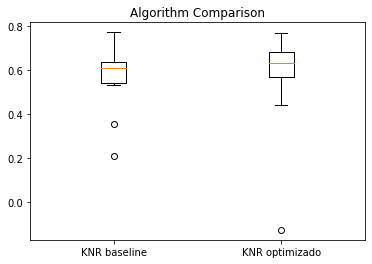

Resultados en el test set:


,modelo,rmse,mape,r2
0,KNR baseline,0.080360,1.996749e+12,0.625781
1,KNR optimizado,0.071055,1.162075e+12,0.707426


In [32]:
modelos_knr = {'KNR baseline': knr0,
               'KNR optimizado': knr1}
comparar_modelos(modelos_knr, x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled)

### LGBMRegressor - Ajuste de hiperparámetros

In [113]:
model = LGBMRegressor(random_state=0)
param_search = { 
   'num_leaves': [20, 25, 31, 35],
   'max_depth': [4, 6, 8, 10, 12, 14, -1],
   'learning_rate' : [0.1, 0.2],
   'n_estimators': [50, 100, 200], 
}

gs_cv_lgbm = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2', verbose=2)
gs_cv_lgbm.fit(x_train, y_train)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learni

[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=200, num_leaves=

[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=

[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=35; total t

[CV] END learning_rate=0.1, max_depth=8, n_estimators=200, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=200, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=200, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=200, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=

[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=25; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, 

[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=25; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=25; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=25; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, 

[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=50, num_leaves=

[CV] END learning_rate=0.1, max_depth=14, n_estimators=200, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=200, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=200, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=200, num_leaves=35; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=200, num_leaves=35; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=200, num_leaves=35; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=200, num_leaves=35; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=14, n_estimators=200, num_leaves=35; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=50, num

[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=20; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=20; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=20; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=20; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=200, 

[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=4, n_estimators=100, num_leaves=

[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=50, num_leaves=35; total t

[CV] END learning_rate=0.2, max_depth=6, n_estimators=200, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=200, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=200, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=200, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=200, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=200, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=200, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=200, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=50, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=50, num_leaves=20;

[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=8, n_estimators=200, num_leaves=

[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=100, 

[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=12, n_estimators=50, num_leaves=

[CV] END learning_rate=0.2, max_depth=14, n_estimators=100, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=100, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=100, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=100, num_leaves=35; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=100, num_leaves=35; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=200, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=200, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=200, num_leaves=20; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=14, n_estimators=200, 

[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, num_leaves=25; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=-1, n_estimators=100, 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LGBMRegressor(random_state=0),
             param_grid={'learning_rate': [0.1, 0.2],
                         'max_depth': [4, 6, 8, 10, 12, 14, -1],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [20, 25, 31, 35]},
             scoring='r2', verbose=2)

In [114]:
best_model_metrics(gs_cv_lgbm, x_test, y_test, results=True)

R2 score promedio del modelo en train set: 0.9200671903267439
R2 score en test set: 0.9453930956812957
rmse score en test set: 24.496418093869227
mape score en test set: 0.2587618953324724

 Parametros:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'num_leaves': 31}

 Resultados de los mejores 10 modelos:
    param_learning_rate param_max_depth param_n_estimators param_num_leaves  \
21                  0.1               6                200               25   
22                  0.1               6                200               31   
23                  0.1               6                200               35   
35                  0.1               8                200               35   
59                  0.1              12                200               35   
69                  0.1              14                200               25   
71                  0.1              14                200               35   
83                  0.1              -1        

In [33]:
# Argumentos por default
lgbm0 = LGBMRegressor(random_state=0)
# Mejor del gridsearch
lgbm1 = LGBMRegressor(random_state=0, num_leaves=31, max_depth=6, learning_rate=0.1, n_estimators=200)

Resultados con cross validation en el train set para el período completo (2018-2019):
LGBM baseline: 0.918162 (0.070495)
LGBM optimizado: 0.920067 (0.064607)


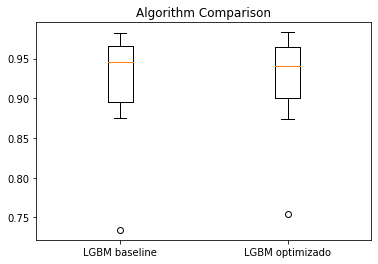

Resultados en el test set:


,modelo,rmse,mape,r2
0,LGBM baseline,25.378882,0.230821,0.941388
1,LGBM optimizado,24.496418,0.258762,0.945393


In [34]:
modelos_lgbm = {'LGBM baseline': lgbm0, 
                'LGBM optimizado': lgbm1}
comparar_modelos(modelos_lgbm, x_train, x_test, y_train, y_test)

### Support Vector Machine Regression (SVR) - Ajuste de hiperparámetros

In [49]:
param_svr = {'kernel' : ('linear', 'rbf'),
             'C' : [1,5,10],
             'degree' : [3,8],
             'coef0' : [0.01,10,0.5],
             'gamma' : ('auto','scale')}

modelsvr = SVR()

gs_cv_svr = GridSearchCV(estimator=modelsvr, cv=tscv, param_grid=param_svr, scoring = 'r2', verbose=2)
gs_cv_svr.fit(x_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.2s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.2s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.3s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.4s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, degree=3

[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.3s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.4s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=10, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, d

[CV] END C=1, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.2s
[CV] END C=1, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.3s
[CV] END C=1, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.3s
[CV] END C=1, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=1, coef0=0.5, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...C=1, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.5, degree=8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...C=1, coef0=0.5, 

[CV] END C=5, coef0=0.01, degree=8, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=5, coef0=0.01, degree=8, gamma=scale, kernel=linear; total time=   0.3s
[CV] END C=5, coef0=0.01, degree=8, gamma=scale, kernel=linear; total time=   0.6s
[CV] END C=5, coef0=0.01, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=5, coef0=0.01, degree=8, gamma=scale, kernel=linear; total time=   0.1s
[CV] END .C=5, coef0=0.01, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=5, coef0=0.01, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=5, coef0=0.01, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=5, coef0=0.01, degree=8, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .C=5, coef0=0.01, degree=8, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .C=5, coef0=0.01, degree=8, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .C=5, coef0=0.01, degree=8, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .C=5, coe

[CV] END C=5, coef0=0.5, degree=3, gamma=auto, kernel=linear; total time=   0.4s
[CV] END C=5, coef0=0.5, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=5, coef0=0.5, degree=3, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.2s
[CV] END ...C=5, coef0=0.5, degree=3, gamma=auto, kernel=rbf; total time=   0.2s
[CV] END ...C=5, coef0=0.5, 

[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END C=10, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END C=10, coef0=0.01, degree=8, gamma=auto, kernel=linear; total time=   0.0s
[CV] END C=10, coef0=0.

[CV] END ...C=10, coef0=10, degree=8, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, degree=8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...C=10, coef0=10, degree=8, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...C=10, coef0=10, degree=8, gamma=auto, kernel=rbf; total time=   0.3s
[CV] END ...C=10, coef0=10, degree=8, gamma=auto, kernel=rbf; total time=   0.2s
[CV] END ...C=10, coef0=10, degree=8, gamma=auto, kernel=rbf; total time=   0.3s
[CV] END ...C=10, coef0=10, degree=8, gamma=auto, kernel=rbf; total time=   0.4s
[CV] END C=10, coef0=10, degree=8, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=10, coef0=10, degree=8, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=10, coef0=10, degree=8, gamma=scale, kernel=linear; total time=   0.1s
[CV] END C=10, coef0=10, degree=8, gamma=scale, kernel=linear; total time=   0.1s
[CV] END C=10, coef0=10, degree=8, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=10, coef0=10

[CV] END .C=10, coef0=0.5, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.5, degree=8, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.5, degree=8, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .C=10, coef0=0.5, degree=8, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .C=10, coef0=0.5, degree=8, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .C=10, coef0=0.5, degree=8, gamma=scale, kernel=rbf; total time=   0.4s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'coef0': [0.01, 10, 0.5],
                         'degree': [3, 8], 'gamma': ('auto', 'scale'),
                         'kernel': ('linear', 'rbf')},
             scoring='r2', verbose=2)

In [50]:
best_model_metrics(gs_cv_svr, x_test, y_test, results=True)

R2 score promedio del modelo en train set: 0.9999994376747754
R2 score en test set: 0.9999994685045925
rmse score en test set: 0.07642378894760461
mape score en test set: 0.008192124573135376

 Parametros:
{'C': 1, 'coef0': 0.01, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}

 Resultados de los mejores 10 modelos:
   param_C param_coef0 param_degree param_gamma param_kernel  \
0        1        0.01            3        auto       linear   
2        1        0.01            3       scale       linear   
4        1        0.01            8        auto       linear   
6        1        0.01            8       scale       linear   
8        1          10            3        auto       linear   
10       1          10            3       scale       linear   
12       1          10            8        auto       linear   
14       1          10            8       scale       linear   
16       1         0.5            3        auto       linear   
18       1         0.5            3     

In [51]:
# Argumentos por default
svr0 = SVR()
# Mejor del gridsearch
svr1 = SVR(C=1, coef0=0.01, degree=3, gamma='auto', kernel='linear')

Resultados con cross validation en el train set para el período completo (2018-2019):
SVR baseline: 0.357340 (0.164301)
SVR optimizado: 0.999999 (0.000000)


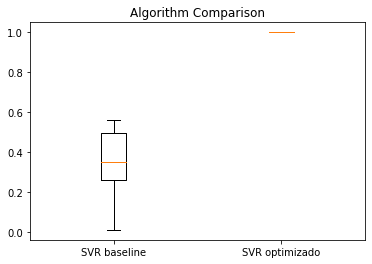

Resultados en el test set:


,modelo,rmse,mape,r2
0,SVR baseline,66.520734,1.619384,0.597323
1,SVR optimizado,0.076424,0.008192,0.999999


In [52]:
modelos_svr = {'SVR baseline': svr0, 
               'SVR optimizado': svr1}
comparar_modelos(modelos_svr, x_train, x_test, y_train, y_test)

### Voting

No vamos a incluir el KNeighborsRegressor en el voting ya que su performance era mucho menor que la del resto de los modelos

#### XGB y Random Forest

In [119]:
np.random.seed(3)
w = []
for i in range(30):
    w.append(np.random.rand(1,2).round(1)[0])

In [120]:
param_grid_voting = { 'weights': [None] + w}

In [121]:
from sklearn.ensemble import VotingClassifier
voting = VotingRegressor([('XGB', xgb3), ('RFR', rf1)])

gs_cv_voting = GridSearchCV(voting, param_grid_voting, scoring='r2', cv=tscv, verbose=2)
gs_cv_voting.fit(x_train, y_train)

Fitting 10 folds for each of 31 candidates, totalling 310 fits
[CV] END .......................................weights=None; total time=   1.3s
[CV] END .......................................weights=None; total time=   1.3s
[CV] END .......................................weights=None; total time=   1.5s
[CV] END .......................................weights=None; total time=   1.7s
[CV] END .......................................weights=None; total time=   1.8s
[CV] END .......................................weights=None; total time=   1.9s
[CV] END .......................................weights=None; total time=   2.1s
[CV] END .......................................weights=None; total time=   2.5s
[CV] END .......................................weights=None; total time=   2.6s
[CV] END .......................................weights=None; total time=   2.6s
[CV] END ..................................weights=[0.6 0.7]; total time=   1.2s
[CV] END ..................................wei

[CV] END ..................................weights=[0.3 0.4]; total time=   1.4s
[CV] END ..................................weights=[0.3 0.4]; total time=   1.5s
[CV] END ..................................weights=[0.3 0.4]; total time=   1.7s
[CV] END ..................................weights=[0.3 0.4]; total time=   1.8s
[CV] END ..................................weights=[0.3 0.4]; total time=   2.1s
[CV] END ..................................weights=[0.3 0.4]; total time=   2.1s
[CV] END ..................................weights=[0.3 0.4]; total time=   2.3s
[CV] END ..................................weights=[0.3 0.4]; total time=   2.5s
[CV] END ..................................weights=[0.3 0.4]; total time=   2.7s
[CV] END ..................................weights=[0.3 0.7]; total time=   1.2s
[CV] END ..................................weights=[0.3 0.7]; total time=   1.5s
[CV] END ..................................weights=[0.3 0.7]; total time=   1.6s
[CV] END ...................

[CV] END ..................................weights=[0.4 0.2]; total time=   1.7s
[CV] END ..................................weights=[0.4 0.2]; total time=   1.8s
[CV] END ..................................weights=[0.4 0.2]; total time=   2.0s
[CV] END ..................................weights=[0.4 0.2]; total time=   2.1s
[CV] END ..................................weights=[0.4 0.2]; total time=   2.3s
[CV] END ..................................weights=[0.4 0.2]; total time=   2.5s
[CV] END ..................................weights=[0.4 0.2]; total time=   2.7s
[CV] END ..................................weights=[0.4 0.5]; total time=   1.2s
[CV] END ..................................weights=[0.4 0.5]; total time=   1.4s
[CV] END ..................................weights=[0.4 0.5]; total time=   1.5s
[CV] END ..................................weights=[0.4 0.5]; total time=   1.7s
[CV] END ..................................weights=[0.4 0.5]; total time=   1.8s
[CV] END ...................

[CV] END ..................................weights=[0.7 0.7]; total time=   2.1s
[CV] END ..................................weights=[0.7 0.7]; total time=   2.3s
[CV] END ..................................weights=[0.7 0.7]; total time=   2.4s
[CV] END ..................................weights=[0.7 0.7]; total time=   2.5s
[CV] END ..................................weights=[0.7 0.7]; total time=   2.7s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=VotingRegressor(estimators=[('XGB',
                                                    XGBRegressor(base_score=0.5,
                                                                 booster='gbtree',
                                                                 colsample_bylevel=1,
                                                                 colsample_bynode=1,
                                                                 colsample_bytree=0.8,
                                                                 eval_metric='logloss',
                                                                 gamma=0,
                                                                 gpu_id=-1,
                                                                 importance_type='gain',
                                                                 interaction_constraints='',
         

In [146]:
resultados_voting = best_model_metrics(gs_cv_voting, x_test_scaled, y_test_scaled, results=True, save=True, name='voting.csv', ret=True)

R2 score promedio del modelo en train set: 0.9578169369788864
R2 score en test set: 0.9844893194813235
rmse score en test set: 0.016360302980265785
mape score en test set: 124573123389.17082

 Parametros:
{'weights': array([0.5, 0.1])}

 Resultados de los mejores 10 modelos:
   param_weights                   params  split0_test_score  \
7     [0.6, 0.3]  {'weights': [0.6, 0.3]}           0.854120   
8     [0.7, 0.6]  {'weights': [0.7, 0.6]}           0.841905   
12    [0.4, 0.2]  {'weights': [0.4, 0.2]}           0.854120   
14    [0.3, 0.2]  {'weights': [0.3, 0.2]}           0.848119   
16    [1.0, 0.7]  {'weights': [1.0, 0.7]}           0.846981   
18    [0.4, 0.1]  {'weights': [0.4, 0.1]}           0.863842   
19    [0.7, 0.6]  {'weights': [0.7, 0.6]}           0.841905   
20    [0.4, 0.2]  {'weights': [0.4, 0.2]}           0.854120   
24    [0.6, 0.3]  {'weights': [0.6, 0.3]}           0.854120   
27    [0.5, 0.1]  {'weights': [0.5, 0.1]}           0.865797   
28    [0.5, 0.4]  {'

Resultados con cross validation en el train set para el período completo (2018-2019):
Voting baseline: 0.919370 (0.052327)
Voting optimizado: 0.959451 (0.038726)


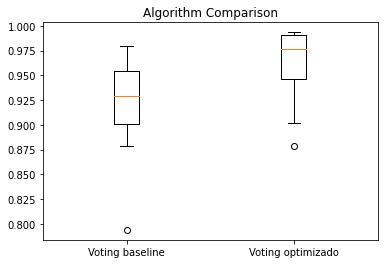

Resultados en el test set:


,modelo,rmse,mape,r2
0,Voting baseline,21.219175,0.259929,0.959027
1,Voting optimizado,12.191981,0.204646,0.986473


In [35]:
# Baseline
voting0 = VotingRegressor([('XGB', XGBRegressor(seed=42)), ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))])
# Mejor del gridsearch
voting1 = VotingRegressor([('XGB', xgb3), ('RFR', rf1)], weights=[0.5, 0.1])

modelos_voting1 = {'Voting baseline': voting0,
                  'Voting optimizado': voting1}
comparar_modelos(modelos_voting1, x_train, x_test, y_train, y_test)

#### XGB,  Random Forest y LGBM

In [126]:
np.random.seed(3)
w = []
for i in range(30):
    w.append(np.random.rand(1,3).round(1)[0])

param_grid_voting3 = { 'weights': [None] + w}

In [127]:
voting3 = VotingRegressor([('XGB', xgb3), ('RFR', rf1), ('LGBM', lgbm1)])

gs_cv_voting3 = GridSearchCV(voting3, param_grid_voting3, scoring='r2', cv=tscv, verbose=2)
gs_cv_voting3.fit(x_train, y_train)

Fitting 10 folds for each of 31 candidates, totalling 310 fits
[CV] END .......................................weights=None; total time=   1.2s
[CV] END .......................................weights=None; total time=   1.4s
[CV] END .......................................weights=None; total time=   1.5s
[CV] END .......................................weights=None; total time=   1.7s
[CV] END .......................................weights=None; total time=   1.8s
[CV] END .......................................weights=None; total time=   2.0s
[CV] END .......................................weights=None; total time=   2.1s
[CV] END .......................................weights=None; total time=   2.3s
[CV] END .......................................weights=None; total time=   2.5s
[CV] END .......................................weights=None; total time=   2.6s
[CV] END ..............................weights=[0.6 0.7 0.3]; total time=   1.2s
[CV] END ..............................weights

[CV] END ..............................weights=[0.2 0.4 0.9]; total time=   1.4s
[CV] END ..............................weights=[0.2 0.4 0.9]; total time=   1.7s
[CV] END ..............................weights=[0.2 0.4 0.9]; total time=   1.8s
[CV] END ..............................weights=[0.2 0.4 0.9]; total time=   2.1s
[CV] END ..............................weights=[0.2 0.4 0.9]; total time=   2.4s
[CV] END ..............................weights=[0.2 0.4 0.9]; total time=   2.3s
[CV] END ..............................weights=[0.2 0.4 0.9]; total time=   2.4s
[CV] END ..............................weights=[0.2 0.4 0.9]; total time=   2.6s
[CV] END ..............................weights=[0.2 0.4 0.9]; total time=   2.8s
[CV] END ..............................weights=[1.  0.7 0.9]; total time=   1.2s
[CV] END ..............................weights=[1.  0.7 0.9]; total time=   1.4s
[CV] END ..............................weights=[1.  0.7 0.9]; total time=   1.6s
[CV] END ...................

[CV] END ..............................weights=[0.7 0.7 0.7]; total time=   1.7s
[CV] END ..............................weights=[0.7 0.7 0.7]; total time=   1.9s
[CV] END ..............................weights=[0.7 0.7 0.7]; total time=   2.1s
[CV] END ..............................weights=[0.7 0.7 0.7]; total time=   2.2s
[CV] END ..............................weights=[0.7 0.7 0.7]; total time=   2.4s
[CV] END ..............................weights=[0.7 0.7 0.7]; total time=   2.6s
[CV] END ..............................weights=[0.7 0.7 0.7]; total time=   2.8s
[CV] END ..............................weights=[0.4 0.7 0.3]; total time=   1.2s
[CV] END ..............................weights=[0.4 0.7 0.3]; total time=   1.5s
[CV] END ..............................weights=[0.4 0.7 0.3]; total time=   1.6s
[CV] END ..............................weights=[0.4 0.7 0.3]; total time=   1.8s
[CV] END ..............................weights=[0.4 0.7 0.3]; total time=   1.9s
[CV] END ...................

[CV] END ..............................weights=[0.3 0.9 0.8]; total time=   2.1s
[CV] END ..............................weights=[0.3 0.9 0.8]; total time=   2.2s
[CV] END ..............................weights=[0.3 0.9 0.8]; total time=   2.4s
[CV] END ..............................weights=[0.3 0.9 0.8]; total time=   2.6s
[CV] END ..............................weights=[0.3 0.9 0.8]; total time=   2.8s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=VotingRegressor(estimators=[('XGB',
                                                    XGBRegressor(base_score=0.5,
                                                                 booster='gbtree',
                                                                 colsample_bylevel=1,
                                                                 colsample_bynode=1,
                                                                 colsample_bytree=0.8,
                                                                 eval_metric='logloss',
                                                                 gamma=0,
                                                                 gpu_id=-1,
                                                                 importance_type='gain',
                                                                 interaction_constraints='',
         

In [149]:
resultados_voting3 = best_model_metrics(gs_cv_voting3, x_test, y_test, results=True, save=True, name='voting3.csv', ret=True)

R2 score promedio del modelo en train set: 0.954903161240318
R2 score en test set: 0.9821499592476379
rmse score en test set: 14.00549340196159
mape score en test set: 0.2080358144006305

 Parametros:
{'weights': array([0.8, 0.4, 0.1])}

 Resultados de los mejores 10 modelos:
      param_weights                        params  split0_test_score  \
4   [0.4, 0.0, 0.5]  {'weights': [0.4, 0.0, 0.5]}           0.872322   
5   [0.6, 0.3, 0.7]  {'weights': [0.6, 0.3, 0.7]}           0.871184   
6   [0.6, 0.0, 0.6]  {'weights': [0.6, 0.0, 0.6]}           0.880456   
8   [0.7, 0.4, 0.2]  {'weights': [0.7, 0.4, 0.2]}           0.874665   
11  [1.0, 0.7, 0.9]  {'weights': [1.0, 0.7, 0.9]}           0.871500   
12  [0.8, 0.4, 0.1]  {'weights': [0.8, 0.4, 0.1]}           0.872739   
16  [0.9, 0.6, 0.3]  {'weights': [0.9, 0.6, 0.3]}           0.871997   
22  [0.6, 0.3, 0.4]  {'weights': [0.6, 0.3, 0.4]}           0.878369   
25  [0.7, 0.5, 0.6]  {'weights': [0.7, 0.5, 0.6]}           0.871561   
27 

Resultados con cross validation en el train set para el período completo (2018-2019):
Voting baseline: 0.919370 (0.052327)
Voting optimizado: 0.954903 (0.039667)


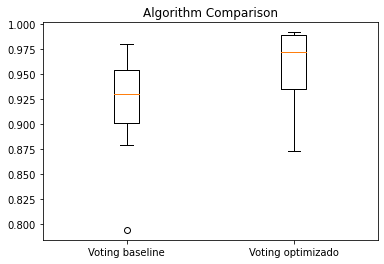

Resultados en el test set:


,modelo,rmse,mape,r2
0,Voting baseline,21.219175,0.259929,0.959027
1,Voting optimizado,14.005493,0.208036,0.982150


In [36]:
# Mejor del gridsearch
voting3 = VotingRegressor([('XGB', xgb3), ('RFR', rf1), ('LGBM', lgbm1)], weights=[0.8, 0.4, 0.1])

modelos_voting3 = {'Voting baseline': voting0,
                   'Voting optimizado': voting3}
comparar_modelos(modelos_voting3, x_train, x_test, y_train, y_test)

#### Comparación final

Resultados con cross validation en el train set para el período completo (2018-2019):
XGB: 0.961997 (0.037221)
RF: 0.912734 (0.060771)
LGBM: 0.920067 (0.064607)


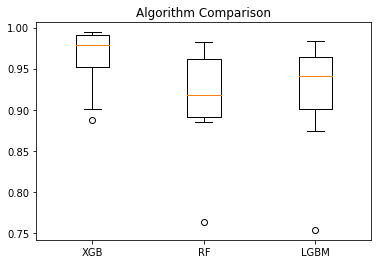

Resultados en el test set:


,modelo,rmse,mape,r2
0,XGB,11.547643,0.201504,0.987865
1,RF,22.110115,0.266866,0.955514
2,LGBM,24.496418,0.258762,0.945393


In [37]:
modelos_solos = {'XGB': xgb3,
                 'RF': rf1,
                 'LGBM': lgbm1}
comparar_modelos(modelos_solos, x_train, x_test, y_train, y_test)

Resultados con cross validation en el train set para el período completo (2018-2019):
Baseline: 0.919370 (0.052327)
XGB y RF: 0.959451 (0.038726)
XGB, RF y LGBM: 0.954903 (0.039667)


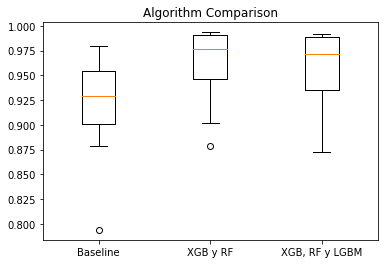

Resultados en el test set:


,modelo,rmse,mape,r2
0,Baseline,21.219175,0.259929,0.959027
1,XGB y RF,12.191981,0.204646,0.986473
2,"XGB, RF y LGBM",14.005493,0.208036,0.982150


In [38]:
modelos_voting4 = {'Baseline': voting0,
                  'XGB y RF': voting1,
                  'XGB, RF y LGBM': voting3}
comparar_modelos(modelos_voting4, x_train, x_test, y_train, y_test)

## Conclusión

De los distintos votings, con el que se obtuvo mejores resultados fue el que combinaba XGBRegressor con parametros:
- random_state=0
- subsample=0.6
- n_estimators=1000
- max_depth=1
- learning_rate=0.2
- colsample_bytree=0.8
- gamma=0
- reg_alpha=0.01
- reg_lambda=1

y RandomForestRegressor con parametros:
- random_state=0
- criterion='mse'
- max_depth=11
- max_features='auto'
- min_samples_leaf=2
- n_estimators=50

y pesos: 0.5 para XGBRegressor y 0.1 para RandomForestRegressor.

Sin embargo, se puede observar que el modelo XGBRegressor solo, con los parámetros antes mencionados, tiene una mejor performance que la del voting. Por lo tanto, es el modelo elegido.

In [39]:
modelo_final = XGBRegressor(use_label_encoder=False, random_state=0,
                            subsample=0.6, n_estimators=1000, max_depth=1, learning_rate=0.2, colsample_bytree=0.8,
                            gamma=0, reg_alpha=0.01, reg_lambda=1)

### Resource

Multicolinealidad 

https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea

Normalizacion y Standarizacion

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

Time series cross validation

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a

Remove Trend and Autocorrelacion 

https://towardsdatascience.com/time-series-analysis-using-pandas-in-python-f726d87a97d8